Notebook to try various baseline upscaling estimates

In [209]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate

# import powerlaw

analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/'

## Start with Kuhn 2021 regression equations from BAWLD-CH4.

### Try to replicate coefficients

In [98]:
## Load
df = pd.read_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/archive/BAWLD_CH4_Aquatic.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Filter and pre-process
df.query("SEASON == 'Icefree' ", inplace=True) # and `D.METHOD` == 'CH'
df.dropna(subset=['SA', 'CH4.D.FLUX', 'TEMP'], inplace=True)

## if I want transformed y as its own var
df['CH4.D.FLUX.LOG'] = np.log10(df['CH4.D.FLUX']+1) 

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

## View
df.head(2)

Filtered out 341 values (212 remaining).
Variables: Index(['ï»¿ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.D.FLUX.LOG'],
      dtype='object')


,ï»¿ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,ICEFREE.DAYS,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.D.FLUX.LOG
4,5,2,Bastviken et al. 2004,WIK,2004,Sweden,Bisen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.230449
6,7,2,Bastviken et al. 2004,WIK,2004,Sweden,Grunnen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.623249


<AxesSubplot:ylabel='Frequency'>

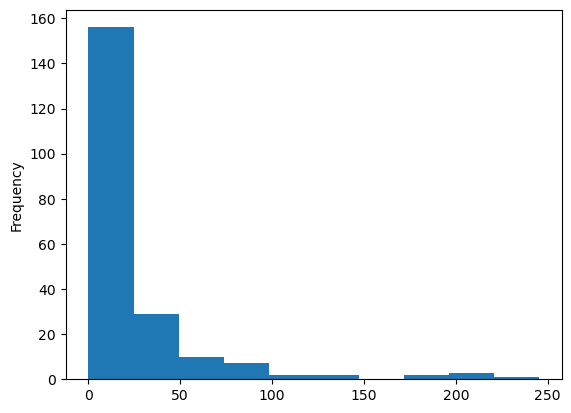

In [99]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()

In [100]:
## Linear models (regression)

formula = "np.log10(Q('Seasonal.Diff.Flux')) ~ SA + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula, data=df).fit()
# print(f'R2: {model1.rsquared:0.3}')
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log10(Q('Seasonal.Diff.Flux'))   R-squared:                       0.219
Model:                                           OLS   Adj. R-squared:                  0.211
Method:                                Least Squares   F-statistic:                     26.40
Date:                               Mon, 06 Feb 2023   Prob (F-statistic):           7.85e-11
Time:                                       10:04:34   Log-Likelihood:                -140.89
No. Observations:                                191   AIC:                             287.8
Df Residuals:                                    188   BIC:                             297.5
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5694      0.138     -4.133      0.000      -0.841      -0.298
SA            -0.0824      0.027     -3.104      0.002      -0.135      -0.030
TEMP           0.0557      0.010      5.619      0.000       0.036       0.075
==============================================================================
Omnibus:                        6.269   Durbin-Watson:                   1.470
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.444
Skew:                          -0.317   Prob(JB):                       0.0399
Kurtosis:                       3.638   Cond. No.                         51.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Apply models

In [101]:
## I/O This file is the output of QGIS join nearest and when there are multiple nearest BAWLD grid cells (didst 0) to a large lake, multiple rows are created.
# dfHL = pd.read_excel('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.dbf', usecols=['Hylak_id', 'Shp_Area', 'BAWLDCell_'])
gdfHL = gpd.read_file('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp', usecols=['Hylak_id', 'Shp_Area', 'BAWLDCell_'])
gdfHL_save = gdfHL


In [73]:
## Take only the first entry for each lake so join  becomes one-one
gdfHL = gdfHL.groupby('Hylak_id').first()

### Join in climate data from WorldClim using pypi package latlon_utils (netcdf is in ~/.local/share/latlon_utils/)

In [105]:
## Join in BAWLD attributes
gdfBAWLD = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')
gdfHL = gdfHL.merge(gdfBAWLD[['Cell_ID', 'Long', 'Lat']], left_on='BAWLDCell_', right_on='Cell_ID')

gdfHL.head(3)

,Hylak_id,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,feature_y,nearest_x,nearest_y,geometry,Cell_ID,Long,Lat
0,2,0.092034,0.071082,57.810849,42.026024,30656.007,30450.64,11887,1,0.0,-122.000000,65.500000,-122.000000,65.500000,"POLYGON ((-119.78782 67.03574, -119.78637 67.0...",11887,-122.25,65.75
1,414668,10.500000,5.500000,84.000000,0.000000,0.200,0.20,11887,1,0.0,-122.457390,65.835295,-122.457390,65.835295,"POLYGON ((-122.45739 65.83529, -122.45475 65.8...",11887,-122.25,65.75
2,414869,17.426273,10.991957,71.581769,0.000000,0.373,0.37,11887,1,0.0,-122.398134,65.826753,-122.398134,65.826753,"POLYGON ((-122.39813 65.82675, -122.39248 65.8...",11887,-122.25,65.75


### Computing temperature means for each lake

In [181]:
## Try dask-ifying and chunking and applying
import dask.dataframe as dd
import dask_geopandas as dgpd
# ddf_HL = dd.from_pandas(gdfHL, chunksize=10000) 
dgdf_HL = dgpd.from_geopandas(gdfHL, chunksize=10000) # assume default sorting provides geosptial partitions, not that it shold matter

In [182]:
## Def functions
def applyGet_climate(ddf):
    '''ddf needs to have 'Lat' and 'Long' attributes'''
    return get_climate(ddf.loc[:, ['Lat']].to_numpy().T.tolist()[0], ddf.loc[:, ['Long']].to_numpy().T.tolist()[0], load_data=True)['tavg']

In [167]:
## Figure out the meta template argument...
ddf_HL.partiloc[0:0, :]

,Hylak_id,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,feature_y,nearest_x,nearest_y,geometry,Cell_ID,Long,Lat
npartitions=1,,,,,,,,,,,,,,,,,,
0,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,geometry,int64,float64,float64
0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [183]:
## Test
applyGet_climate(gdfHL[:100])
# type(ddf_HL._partitions(0).compute())

jan        feb        mar       apr       mai        jun  \
lat   lon                                                                       
65.75 -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
...                  ...        ...        ...       ...       ...        ...   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   

                     jul        aug       sep       oct        nov        dec  \
lat   lon                                                                       
65.75 -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
...                  ...        ...       ...       ...        ...        ...   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   

                     djf       mam        jja       son       ann  
lat   lon                                                          
65.75 -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
...                  ...       ...        ...       ...       ...  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  

[100 rows x 17 columns]

In [187]:
## Apply
# df_HL_clim = ddf_HL.apply(applyGet_climate, axis=1)
HL_clim = ddf_HL.map_partitions(applyGet_climate).compute()

In [188]:
## View
HL_clim.head(3)

jan       feb        mar       apr       mai        jun  \
lat   lon                                                                      
65.75 -122.25 -24.660522 -23.14801 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.14801 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.14801 -19.419495 -8.281982  1.561279  10.061279   

                     jul        aug       sep       oct        nov        dec  \
lat   lon                                                                       
65.75 -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   

                    djf       mam        jja       son       ann  
lat   lon                                                         
65.75 -122.25 -23.14152 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.14152 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.14152 -8.713399  11.148844 -4.756327 -6.365601

In [241]:
# HL_clim.drop(columns='Hylak_id', inplace=True)

In [249]:
## Check that order is preserved in HL_clim

np.all(HL_clim.reset_index()[['lat','lon']].to_numpy() == gdfHL[['Lat', 'Long']].to_numpy())
# HL_clim.reset_index().loc[9999,'lon']
# gdfHL.loc[9999, 'Long']

True

In [250]:
## join in HL ID
# HL_clim['Hylak_id'] = gdfHL['Hylak_id']
# HL_clim.merge?
HL_clim_jn = pd.concat((HL_clim.reset_index(), gdfHL[['Hylak_id', 'Shp_Area']]), axis=1) # for some reason, just re-assigning column doesn't work

In [252]:
## Write out x2

joined_clim_dir = os.path.join(analysis_dir, 'joined_climate')
os.makedirs(joined_clim_dir, exist_ok=True)

HL_clim_jn.to_csv(os.path.join(joined_clim_dir, 'HL_clim_full.csv'))
HL_clim_jn[['Hylak_id', 'jja', 'Shp_Area']].to_csv(os.path.join(joined_clim_dir, 'HL_clim_jja.csv'))

In [255]:
## Preview file
!head {os.path.join(joined_clim_dir, 'HL_clim_jja.csv')}

,Hylak_id,jja,Shp_Area
0,2,11.148844401041666,30450.64
1,414668,11.148844401041666,0.2
2,414869,11.148844401041666,0.37
3,415195,11.148844401041666,0.1
4,415250,11.148844401041666,0.15
5,415810,11.148844401041666,0.11
6,415986,11.148844401041666,0.28
7,416165,11.148844401041666,0.12
8,416263,11.148844401041666,0.14


In [ ]:
## Join in climate data from WorldClim using pypi package latlon_utils (netcdf is in ~/.local/share/latlon_utils/)


## TODO:
* apply get_climate function over all hydrolakes using BAWLD cell lat/long X
    * Or, if worldclim netcdf is fine-scale, use individual lake lat/long
* Smart dask way is to define an entire processing chain that ends with writing out
* Apply upscaling calc using lake area (Shp_area) and summer temp
* Plot, sum, profit!

In [77]:
## Baseline estimate
gdfHL['Est_mg_day'] = gdfHL[] # mg CH4 / day

,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,feature_y,nearest_x,nearest_y,geometry
Hylak_id,,,,,,,,,,,,,,
2,0.092034,0.071082,57.810849,42.026024,30656.007,30450.64,11887,1,0.0,-122.000000,65.500000,-122.000000,65.500000,"POLYGON ((-119.78782 67.03574, -119.78637 67.0..."
3,0.232737,0.198573,4.089538,95.479152,26893.426,26734.29,7387,1,0.0,-113.000000,61.500000,-113.000000,61.500000,"POLYGON ((-109.93976 62.95851, -109.93831 62.9..."
4,16.666667,7.051282,73.717949,2.564103,24018.110,23923.04,1009,1,0.0,-97.514581,52.000000,-97.514581,52.000000,"POLYGON ((-98.80636 53.88021, -98.80578 53.880..."
10,3.316583,1.005025,66.080402,29.597990,17544.685,17444.01,7514,1,0.0,31.000000,61.500000,31.000000,61.500000,"POLYGON ((30.88438 61.74966, 30.88663 61.74813..."
11,33.898305,7.627119,51.694915,5.084746,32101.131,31967.85,938,1,0.0,104.855893,51.500000,104.855893,51.500000,"POLYGON ((109.74514 55.86611, 109.74541 55.865..."
19,0.304422,0.289309,11.650648,87.755621,1065.297,1058.07,12411,1,0.0,-160.563645,66.362858,-160.563645,66.362858,"POLYGON ((-160.81470 66.65479, -160.76426 66.6..."
20,0.798935,4.793609,14.247670,80.159787,4905.846,4872.70,12575,1,0.0,-70.500000,66.267521,-70.500000,66.267521,"POLYGON ((-70.99172 67.03337, -70.98963 67.033..."
21,0.513052,0.573609,85.028117,13.885222,1038.687,1031.69,13108,1,0.0,-113.388914,66.500000,-113.388914,66.500000,"POLYGON ((-112.94925 66.55554, -112.94671 66.5..."
22,1.319726,0.866495,85.292121,12.521658,1060.826,1053.82,11303,1,0.0,-110.500000,65.425464,-110.500000,65.425464,"POLYGON ((-111.29301 66.04900, -111.29351 66.0..."


In [70]:
import dbfread

ModuleNotFoundError: No module named 'dbfread'